In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from utils import Diffusion

## MNIST Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1,1]
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataset_v = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
dataloader_v = torch.utils.data.DataLoader(dataset_v, batch_size=128, shuffle=False)

## using cosin schedule instead of leanear

In [3]:
def cosine_schedule(timesteps, s=0.008):
    t = np.linspace(0, timesteps, timesteps + 1)
    alphas_cumprod = np.cos(((t / timesteps) + s) / (1 + s) * (np.pi / 2)) ** 2
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, 0, 0.999)  # Ensure numerical stability

timesteps = 64  # Number of steps
betas = cosine_schedule(timesteps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(torch.tensor(alphas), dim=0)  # Compute cumulative alpha product

# diffusion
- this is the main fromula to calculate the noisy image at any given time t   
    ``` x_t = sqrt(alpha_t) * original_image + sqrt(1 - alpha_t) * noise ```

- how to revers get the image from the the predicted noise, hey thats easy just do the alg  
    ``` x_t - sqrt(1 - alpha_t) * noise / sqrt(alpha_t) ```

In [4]:
def apply_diffusion(x_0, alphas_cumprod, timesteps):
    """
    Applies the diffusion process on an image using a cosine noise schedule.
    x_0: Original image tensor.
    alphas_cumprod: Precomputed schedule values.
    timesteps: Number of diffusion steps.
    """
    t = torch.randint(0, timesteps, (x_0.shape[0],), device=x_0.device)  # Random timestep for each image
    noise = torch.randn_like(x_0)  # Sample Gaussian noise
    
    alpha_bar_t = alphas_cumprod[t].view(-1, 1, 1, 1)  # Reshape for broadcasting
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise  # Add noise

    return x_t.to(torch.float32), t, noise.to(torch.float32)

# Test with a batch
for images, _ in dataloader:
    image, t, noise = apply_diffusion(images, alphas_cumprod, timesteps)
    break  # Only process one batch

## visvalizion the destroction

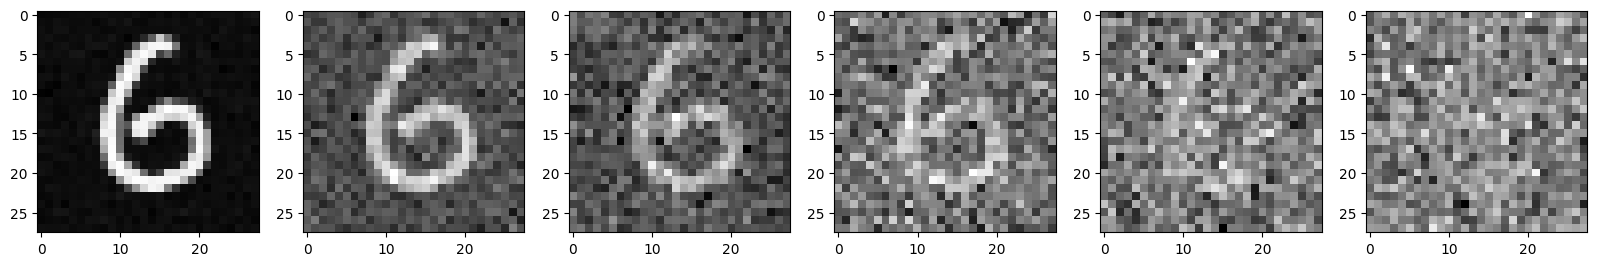

In [5]:
fig , ax = plt.subplots(1, 6, figsize=(20, 3))

for i in range(6):
    image, _, _ = apply_diffusion(images, alphas_cumprod, 64)
    noise = torch.randn_like(image)
    alpha_bar_t = alphas_cumprod[i*10].view(-1, 1, 1, 1)  # Reshape for broadcasting
    image = torch.sqrt(alpha_bar_t) * images + torch.sqrt(1 - alpha_bar_t) * noise  # Add noise
    ax[i].imshow(image[0].squeeze().detach().numpy(), cmap='gray')

## model Declaration & parameters

In [6]:
model = Diffusion(1, 1, 64).cuda()
epochs=500
lr=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.L1Loss()  # Mean Squared Error (Predicting Noise)

## training loop

In [7]:
train_losses = []
valid_losses = []
best_loss = 1e9

for epoch in range(epochs):
    t_epoch_loss = 0
    v_epoch_loss = 0
    model.train()
    for images, _ in dataloader:
        optimizer.zero_grad()
        image, t, noise = apply_diffusion(images, alphas_cumprod, timesteps)  # Get noisy images
        image, t, noise = image.cuda(), t.cuda(), noise.cuda()
        predicted_noise = model(image, t)  # Predict the noise
        
        t_loss = loss_fn(predicted_noise, noise)  # Compare with actual noise
        t_loss.backward()
        optimizer.step()
        t_epoch_loss += t_loss.item()

    model.eval()
    with torch.no_grad():
        for images, _ in dataloader_v:
            image, t, noise = apply_diffusion(images, alphas_cumprod, timesteps)  # Get noisy images
            image, t, noise = image.cuda(), t.cuda(), noise.cuda()
            predicted_noise = model(image, t)  # Predict the noise
            v_loss = loss_fn(predicted_noise, noise)  # Compare with actual noise
            v_epoch_loss += v_loss.item()


    t_epoch_loss /= len(dataloader)
    v_epoch_loss /= len(dataloader_v)
    train_losses.append(t_epoch_loss)
    valid_losses.append(v_epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {t_epoch_loss:.4f}")
    print(f"Epoch {epoch+1}, Validation Loss: {v_epoch_loss:.4f}")
    if v_epoch_loss < best_loss:
        best_loss = v_epoch_loss
        torch.save(model.state_dict(), 'best_model.pt')

KeyboardInterrupt: 

In [ ]:
def denoise(model, timesteps):
    x_t = torch.randn((1, 1, 28, 28)).cuda() # Start with pure noise
    for t in reversed(range(timesteps)):
        predicted_noise = model(x_t.to(torch.float32), torch.tensor([t]).cuda())  # Predict noise
        alpha_bar_t = alphas_cumprod[t].view(-1, 1, 1, 1).cuda()
        x_t = (x_t - torch.sqrt(1 - alpha_bar_t) * predicted_noise).cuda() / torch.sqrt(alpha_bar_t).cuda()  # Reverse step
    return x_t

with torch.no_grad():
    generated_image = denoise(model, 64)
    
plt.imshow(generated_image.cpu().squeeze().detach().numpy(), cmap="gray")
plt.title("Generated Image")
plt.show()
